In [1]:
%%latex
\tableofcontents

<IPython.core.display.Latex object>

# Setup

## Import Libraries

In [2]:
print ('Install Packages')

import sys, copy, math, time, os

print ('Python version: {}'.format(sys.version))

#from collections import Counter

import numpy as np
print ('NumPy version: {}'.format(np.__version__))
np.set_printoptions(suppress=True)

import scipy as sc
print ('SciPy version:  {}'.format(sc.__version__))

import tensorflow as tf
print ('TensorFlow version:  {}'.format(tf.__version__))
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

from tensorflow import keras
print ('Keras version:  {}'.format(keras.__version__))

from keras import layers
import keras.backend as K
from keras.layers import IntegerLookup
from keras.layers import Normalization
from keras.layers import StringLookup
from keras.utils import get_custom_objects
from keras.utils import tf_utils

from keras.models import Sequential
from keras.layers import Dense

#from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier

import pandas as pd
print ('Pandas version:  {}'.format(pd.__version__))
pd.set_option('display.max_rows', 500)

import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
#    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size': 12,
})
#matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')
import matplotlib.pyplot as plt
%matplotlib inline

# Library for reading Microsoft Access files
#import pandas_access as mdb

import sklearn
print ('SciKit-Learn version: {}'.format(sklearn.__version__))
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

import imblearn
print ('Imbalanced-Learn version: {}'.format(imblearn.__version__))
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import EasyEnsembleClassifier

#!pip install pydot

# Set Randomness.  Copied from https://www.kaggle.com/code/abazdyrev/keras-nn-focal-loss-experiments
import random
#np.random.seed(42) # NumPy
#random.seed(42) # Python
#tf.random.set_seed(42) # Tensorflow

print ('Finished Installing Packages')

Install Packages
Python version: 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:26:08) [Clang 14.0.6 ]
NumPy version: 1.24.2
SciPy version:  1.7.3


/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TensorFlow version:  2.11.0
Keras version:  2.11.0
Pandas version:  1.5.3
SciKit-Learn version: 1.2.2
Imbalanced-Learn version: 0.10.1
Finished Installing Packages


# Evaluate Models

## Metrics

In [3]:
def custom_metric(y_true, y_pred):
    y_true = tf.dtypes.cast(y_true, tf.float64)
    y_pred = tf.dtypes.cast(y_pred, tf.float64)
    P = K.sum(y_true)
    N = K.sum(1 - y_true)
    # Note that Tensorflow and Keras round using "banker's rounding,"
    # where halves round to the nearest even integer, so
    # round(0.5) = 0, but round (1.5) = 2
    Discrete_y_pred = K.round(y_pred)
    TRUE = K.equal(y_true, Discrete_y_pred)
    TRUE = tf.dtypes.cast(TRUE, tf.float64)
    FALSE = 1-TRUE
    Discrete_TP = Discrete_y_pred * TRUE
    TP = K.sum(Discrete_TP)
    FN = P - TP
    Discrete_TN = (1 - Discrete_y_pred) * TRUE
    TN = K.sum(Discrete_TN)
    FP = N - TN    

#    CM = confusion_matrix(y_true, y_pred)
#    print (CM)
#    P = CM[1][0] + CM[1][1]
#    N = CM[0][0] + CM[0][1]
#    TN = CM[0][0]
#    FP = CM[0][1]
#    FN = CM[1][0]
#    TP = CM[1][1]
#    print ('TP = ', TP, ' FN = ', FN, ' FP = ', FP, ' TN = ', TN)
    
    return P, N, TP, FN, TN, FP

def Test_Custom_Metric():
    y_true = [0.0,1.0,0.0,1.0]
    y_proba = [0.2, 0.49, 0.75, 0.9]
    y_pred = [round(x) for x in y_proba]
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_true = tf.convert_to_tensor(y_true)
    y_pred = tf.convert_to_tensor(y_pred)
    print (y_true)
    print (y_pred)
    P, N, TP, FN, TN, FP = custom_metric(y_true, y_pred)
    print ('TP = ', TP, ' FN = ', FN, ' FP = ', FP, ' TN = ', TN)
    
Test_Custom_Metric()
    

tf.Tensor([0. 1. 0. 1.], shape=(4,), dtype=float64)
tf.Tensor([0 0 1 1], shape=(4,), dtype=int64)
TP =  tf.Tensor(1.0, shape=(), dtype=float64)  FN =  tf.Tensor(1.0, shape=(), dtype=float64)  FP =  tf.Tensor(1.0, shape=(), dtype=float64)  TN =  tf.Tensor(1.0, shape=(), dtype=float64)


In [4]:
def Accuracy_Metric(y_true, y_pred):
    P, N, TP, FN, TN, FP = custom_metric(y_true, y_pred)
    metric = (TP+TN)/(TP + FN + FP + TN + K.epsilon())
    return metric

In [5]:
def Precision_Metric(y_true, y_pred):
    P, N, TP, FN, TN, FP = custom_metric(y_true, y_pred)
    metric = TP/(TP + FP + K.epsilon())
    return metric

In [6]:
def Recall_Metric(y_true, y_pred):
    P, N, TP, FN, TN, FP = custom_metric(y_true, y_pred)
    metric = TP/(TP + FN + K.epsilon())
    return metric

In [7]:
def Balanced_Accuracy_Metric(y_true, y_pred):
    P, N, TP, FN, TN, FP = custom_metric(y_true, y_pred)
    metric = ( TN/(2*(TN + FP + K.epsilon())) + TP/(2*(FN + TP + K.epsilon())))
    return metric

In [8]:
def F1_Metric(y_true, y_pred):
    precision = Precision_Metric(y_true, y_pred)
    recall = Recall_Metric(y_true, y_pred)
    metric = 2/(1/(precision + K.epsilon()) + 1/(recall + K.epsilon()))
    return metric

In [9]:
def Gmean_Metric(y_true, y_pred):
    P, N, TP, FN, TN, FP = custom_metric(y_true, y_pred)
    precision = TP/(TP + FP + K.epsilon())
    specificity = TN/(TN + FP + K.epsilon())
    metric = K.sqrt(precision * specificity)
    return metric

In [10]:
def Balanced_Precision_Metric(y_true, y_pred):
    P, N, TP, FN, TN, FP = custom_metric(y_true, y_pred)
    metric = (TP * N)/(TP * N + FP * P + K.epsilon())
    return metric

In [11]:
def Balanced_F1_Metric(y_true, y_pred):
    precision = Balanced_Precision_Metric(y_true, y_pred)
    recall = Recall_Metric(y_true, y_pred)
    metric = 2/(1/(precision + K.epsilon()) + 1/(recall + K.epsilon()))
    return metric

## Adjust Center of Probability Distribution

In [12]:
def Shift_y_proba(y_test, y_proba, y_pred, filename):
    print ('Shift_y_proba()')
    print ()
    N_median = np.median(y_proba[np.array(y_test)==0])
    P_median = np.median(y_proba[np.array(y_test)==1])
    center = (N_median + P_median)/2
    print ('N_median = %.3f, P_median = %.3f, center = %.3f' % (N_median, P_median, center))

    y_proba = y_proba - center + 0.5
    y_proba = np.where (y_proba < 0.0, 0.0, y_proba)
    y_proba = np.where (y_proba > 1.0, 1.0, y_proba)
    y_pred = K.round(y_proba)

    N_median = np.median(y_proba[np.array(y_test)==0])
    P_median = np.median(y_proba[np.array(y_test)==1])
    center = (N_median + P_median)/2
    print ('N_median = %.3f, P_median = %.3f, center = %.3f' % (N_median, P_median, center))
    
    print ()
    
    return y_test, y_proba, y_pred, filename
    

In [13]:
def Linear_Transform_y_proba(y_test, y_proba, y_pred, filename):
    print ('Linear_Transform_y_proba()')
    print ()
    
    # I considered two methods.  
    # One was to take the medians of the negative and positive classes and transform them to 0.25 and 0.75.
    # That didn't always work the way I wanted.  
    # Then I tried taking the 0.05 quantile to 0.05 and the 0.95 quantile to 0.95.
    
#    N_median = np.median(y_proba[np.array(y_test)==0])
#    P_median = np.median(y_proba[np.array(y_test)==1])
#    center = (N_median + P_median)/2
#    print ('N_median = %.3f, P_median = %.3f, center = %.3f' % (N_median, P_median, center))
#    y_proba = 0.25/(center - N_median) * (y_proba - center) + 0.5

    
    a = np.quantile(y_proba[np.array(y_test)==0],0.05)
    b = np.quantile(y_proba[np.array(y_test)==1],0.95)
    print ('a = %.3f, b = %.3f' % (a, b))
    y_proba = 0.9/(b-a) * (y_proba - a) + 0.05
    
    y_proba = np.where (y_proba < 0.0, 0.0, y_proba)
    y_proba = np.where (y_proba > 1.0, 1.0, y_proba)
    y_pred = K.round(y_proba)

    print ()
    
    return y_test, y_proba, y_pred, filename
    

In [14]:
def Shift_y_proba_to_FP_equals_r_TP(y_test, y_proba, r_target, filename):
    print ('Shift_y_proba_to_FP_equals_r_TP()')
    print ('y_test is a ', type(y_test))
    print ('y_proba is a ', type(y_proba))
    print ()
    
    
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
    n = 100
    m = np.quantile(C, 0.005)
    print ('Quantiles ', m, M)
    bins = [(M-m) * (x/n) + m for x in range (0, n+1)]
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=False)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=False)
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    """
    df = pd.DataFrame()
    df['TP'] = G
    df['FP'] = H
    roll = 10
    df['TP_RA'] = G.rolling(roll, center=True, min_periods=1).mean()
    df['FP_RA'] = H.rolling(roll, center=True, min_periods=1).mean()
    df['TP/FP'] = df['TP_RA']/df['FP_RA']
    df['TP/FP_RA'] = df['TP/FP'].rolling(roll, center=True, min_periods=1).mean()
    df['Truncate'] = np.where(df['TP/FP_RA']>2,2,df['TP/FP_RA'])
    df['bins'] = bins[:-1]
    df.fillna(0, inplace=True)
    
    #    display(df)
    df_closest = df.iloc[(df['TP/FP_RA'] - r_target).abs().argsort()[:1]]
    center = df_closest['bins'].to_numpy()
    center = center[0]
    center_index = df.index[df['bins'] == center].tolist()
#    print (df_closest)
    print ('center = ', center)
#    print (center_index)
    print ()
    
    print ('Plot TP/FP')
    x = df['bins'].to_numpy()
    y = df['TP/FP_RA'].to_numpy()
    fig = plt.figure(figsize=(2.4,1.8)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    plt.plot(x,y, label='TP/FP', color='black')
    plt.axhline(y=2.0, color='black', linestyle='--', label='2.0')  
    plt.plot([center], [2.0], marker="o", markersize=6, markerfacecolor='black', markeredgecolor='black')
    plt.xticks(
        ticks = [m, center, M], 
        labels = [round(m,3), round(center, 3), round(M,3)],
        rotation=0
    )
    ax.legend()
    plt.title('$\Delta$TP/$\Delta$FP')
    plt.xlabel('$p$')
    plt.ylabel('$\Delta$TP/$\Delta$FP')
    plt.savefig('./Images/' + filename + '_TP_FP.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + filename + '_TP_FP.pgf', bbox_inches="tight", pad_inches=0.05)
    plt.show()
    plt.close()
    """
    
    df = pd.DataFrame()
    df['FP'] = G
    df['TP'] = H
    roll = 10
    df['FP_RA'] = G.rolling(roll, center=True, min_periods=1).mean()
    df['TP_RA'] = H.rolling(roll, center=True, min_periods=1).mean()
    df['FP/TP'] = df['FP_RA']/df['TP_RA']
    df['FP/TP_RA'] = df['FP/TP'].rolling(roll, center=True, min_periods=1).mean()
    df['Truncate'] = np.where(df['FP/TP_RA']>2,2,df['FP/TP_RA'])
    df['bins'] = bins[:-1]
    df.fillna(0, inplace=True)
    
    #    display(df)
    df_closest = df.iloc[(df['FP/TP_RA'] - r_target).abs().argsort()[:1]]
    center = df_closest['bins'].to_numpy()
    center = center[0]
    center_index = df.index[df['bins'] == center].tolist()
#    print (df_closest)
    print ('center = ', center)
#    print (center_index)
    print ()
    
    print ('Plot FP/TP')
    x = df['bins'].to_numpy()
    y = df['FP/TP_RA'].to_numpy()
    fig = plt.figure(figsize=(2.0,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    plt.plot(x,y, label='$\Delta FP/\Delta TP$', color='black')
    plt.axhline(y=2.0, color='black', linestyle='--')  
    plt.plot([center], [2.0], label='(%.3f,2)' % center, marker="o", markersize=6, markerfacecolor='black', markeredgecolor='black')
    plt.xticks(
        ticks = [m, M], 
#        labels = [round(m,3), round(center, 3), round(M,3)],
        labels = [round(m,3), round(M,3)],
        rotation=0
    )
#    ax.annotate('data = (%.3f, %.1f)'%(center, 2.0),(center, 2.0), textcoords='data')
#    plt.text(center,2.0,'(%.3f,%.1f)' % (center, 2.0),horizontalalignment='left', verticalalignment='bottom')
#    plt.title('$\Delta FP/\Delta TP$')
    plt.xlabel('$p$')
    plt.ylabel('$\Delta$FP/$\Delta$TP')
    ax.legend()
    plt.savefig('./Images/' + filename + '_FP_TP.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + filename + '_FP_TP.pgf', bbox_inches="tight", pad_inches=0.05)
    plt.show()
    plt.close()

    # Re-center the distribution
    y_proba = y_proba - center + 0.5

    # Decide which direction to dilate the distribution
    M = np.quantile(y_proba,0.995)
    m = np.quantile(y_proba,0.005)
    right = M-0.5
    left = 0.5-m
    # If the tail to the right is longer, map M to 1 and 0.5 to itself.
    if left < right:
        y_proba = (1/(2*M-1))*(y_proba - 0.5) + 0.5
    # If the tail to the left is longer, map m to 0 and 0.5 to itself.
    if left > right:
        y_proba = (1/(1-2*m))*(y_proba - 0.5) + 0.5
    print ('y_proba unique = ', np.unique(y_proba))
    y_proba = np.clip(y_proba,0,1)
    print ('y_proba unique = ', np.unique(y_proba))
    print ('M, m, left, right = ', M, m, left, right)
    y_pred = K.round(y_proba).numpy()
    
    return y_test, y_proba, y_pred, center, filename
    

In [15]:
def Balance_Proba(y_test, y_proba, y_pred, r_target, filename, title):
    print ('Balance_Proba')
    print (filename)

    y_test, y_proba_New, y_pred_New, center, filename = Shift_y_proba_to_FP_equals_r_TP(y_test, y_proba, r_target, filename)

    N = y_proba[np.array(y_test)==0]
    P = y_proba[np.array(y_test)==1]
    N_median = np.median(N)
    P_median = np.median(P)

    Plot_Prediction(y_test, y_proba, filename, title)
#    ROC(y_test, y_proba, [center, N_median, P_median], filename)    
    ROC(y_test, y_proba, [], filename)    
    Evaluate_Model(y_test, y_proba, y_pred, center, filename)    
    print ()

    filename = filename + '_Linear_Transform'
    title = title + ' Trans'

    N = y_proba_New[np.array(y_test)==0]
    P = y_proba_New[np.array(y_test)==1]
    N_median = np.median(N)
    P_median = np.median(P)
    
    Plot_Prediction(y_test, y_proba_New, filename, title)
#    ROC(y_test, y_proba, [center, N_median, P_median], filename)    
    ROC(y_test, y_proba, [], filename)    
    Evaluate_Model(y_test, y_proba_New, y_pred_New, center, filename)    
    print ()
    


## Evaluate_Model

In [16]:
def Evaluate_Model(y_test, y_proba, y_pred, center, filename):
    print ('Evaluate_Model()')
    y_test = np.array(y_test)
    
    y_proba = y_proba - center + 0.5
    y_proba = np.where (y_proba < 0.0, 0.0, y_proba)
    y_proba = np.where (y_proba > 1.0, 1.0, y_proba)
    
    y_pred = [round(x) for x in y_proba]
    y_pred = np.array(y_pred)
    print ('np.unique(y_proba) = ', np.unique(y_proba))
    print ('np.unique(y_pred) = ', np.unique(y_pred))
    
    CM = confusion_matrix(y_test, y_pred)
    print(CM)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_value = auc(fpr, tpr)
    n = len(y_test)
    TN = CM[0][0]
    FP = CM[0][1]
    FN = CM[1][0]
    TP = CM[1][1]
    Accuracy = (TN+TP)/(TN+FP+FN+TP)
    Precision = TP/(FP+TP)
    Recall = TP/(FN+TP)
    F1 = 2/(1/Precision + 1/Accuracy)
    
    CSV = [[
        filename, 
        TN, FP, FN, TP, 
        center, auc_value,  
        round(100*TN/n,3), round(100*FP/n,3), round(100*FN/n,3), round(100*TP/n,3),
        Accuracy, Precision, Recall, F1
    ]]
    np.savetxt('./Confusion_Matrices/' + filename + '.csv', 
        CSV,
        delimiter =", ", 
        fmt ='% s'
              )
    print ()
    CM = confusion_matrix(y_test, y_pred, normalize='all')
    print(CM)
    print ()

    y_pred = y_pred.ravel()
    y_test = tf.convert_to_tensor(y_test)
    y_pred = tf.convert_to_tensor(y_pred)

    print ('%.3f & Precision \cr ' %  Precision_Metric(y_test, y_pred).numpy())
    print ('%.3f & Recall \cr ' %  Recall_Metric(y_test, y_pred).numpy())
    print ('%.3f & F1 \cr ' %  F1_Metric(y_test, y_pred).numpy())



## Plot Prediction

How to insert a .pgf plot into a \LaTeX document:

\begin{figure}
    \begin{center}
        \input{Plot.pgf}
    \end{center}
    \caption{A PGF histogram from \texttt{matplotlib}.}
\end{figure}


In [17]:
def Plot_Prediction(y_test, y_proba, filename, title):
    print ('Plot_Prediction()')
    print (filename)
    
#    print (y_test)
#    print (y_proba)
#    return 0
#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    bins = [x*0.05 for x in range (21)]
#    bins = [x*0.10 for x in range (11)]
    n = 10
    bins= [x/n for x in range (0, n+1)]
    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=False)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=False)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    G = G/len(y_proba)*100
    H = H/len(y_proba)*100

    fig = plt.figure(figsize=(2.0,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    G.plot(kind='bar', fill=False, ax=ax, width=0.4, position=1)
    H.plot(kind='bar', color='black', ax=ax, width=0.4, position=0)
    plt.xticks(
        ticks = [0, 2.5, 5, 7.5, 10], 
        labels = ['0.0', '0.25', '0.5', '0.75', '1.0'],
        rotation=0
    )
    ax.legend(['Neg', 'Pos'])
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Dataset')
    plt.savefig('./Images/' + filename + '_Pred.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + filename + '_Pred.pgf', bbox_inches="tight", pad_inches=0.05)
    plt.show()
    plt.close()
    print ()


Plot_Prediction()
Test
./Images/Test_Pred_Wide.png


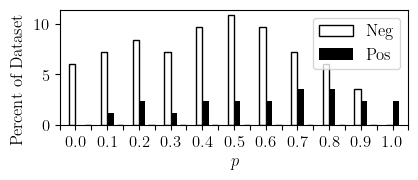

In [18]:
def Plot_Prediction_Wide(y_test, y_proba, filename, title):
    print ('Plot_Prediction()')
    print (filename)
    
#    print ('y_test = ', y_test)
#    print ('y_proba = ',y_proba)

#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    print ("A = pd.DataFrame(y_proba, columns=['HOSPITAL'])")
#    display(A)
#    print ("B = pd.DataFrame(y_test, columns=['HOSPITAL'])")
#    display(B)
#    print ("C = A[B['HOSPITAL']==0]")
#    display(C)
#    print ("D = A[B['HOSPITAL']==1]")
#    display(D)
    n = 20
#    bins= [x/n - 1/(2*n) for x in range (-1, n+3)]
    bins= [x/n for x in range (-1, n+1)]
#    print ('Bins = ', bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=True)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=True)
#    print ("E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=True)")
#    display(E)
#    print ("F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=True)")
#    display(F)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)
#    print ("G = E.value_counts(sort=False)")
#    display(G)
#    print ("H = F.value_counts(sort=False)")
#    display(H)

    G = G/len(y_proba)*100
    H = H/len(y_proba)*100
#    print ("G = G/len(y_proba)*100")
#    display(G)
#    print ("H = H/len(y_proba)*100")
#    display(H)

    fig = plt.figure(figsize=(4.5,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    G.plot(kind='bar', fill=False, ax=ax, width=0.4, position=1)
    H.plot(kind='bar', color='black', ax=ax, width=0.4, position=0)
    ticks = [n/20*i for i in range (-1,22)]
#    print ('ticks = ', ticks)
    plt.xticks(
        ticks = ticks,
        labels = ['','0.0', '', '0.1', '', '0.2', '', '0.3', '', '0.4', '', '0.5', '', '0.6', '', '0.7', '', '0.8', '', '0.9', '', '1.0', ''],
        rotation=0
    )
    ax.legend(['Neg', 'Pos'])
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Dataset')
    ax.yaxis.set_label_coords(-0.1,0.4)
    plt.savefig('../../Dissertation_03_26_24/Figures/' + filename + '_Pred_Wide.pgf', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + filename + '_Pred_Wide.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + filename + '_Pred_Wide.pgf', bbox_inches="tight", pad_inches=0.05)
    print ('./Images/' + filename + '_Pred_Wide.png')
    plt.show()
    plt.close()
    print ()

def Test_Plot_Prediction_Wide():
    
    y_proba = (
        [0.0]*5 + 
        [0.0]*0 + 
        [0.1]*6 + 
        [0.1]*1 + 
        [0.2]*7 + 
        [0.2]*2 + 
        [0.3]*6 + 
        [0.3]*1 + 
        [0.4]*8 + 
        [0.4]*2 + 
        [0.5]*9 + 
        [0.5]*2 + 
        [0.6]*8 + 
        [0.6]*2 + 
        [0.7]*6 + 
        [0.7]*3 + 
        [0.8]*5 + 
        [0.8]*3 + 
        [0.9]*3 + 
        [0.9]*2 + 
        [1.0]*0 + 
        [1.0]*2 
    )
    y_test = (
        [0]*5 + 
        [1]*0 + 
        [0]*6 + 
        [1]*1 + 
        [0]*7 + 
        [1]*2 + 
        [0]*6 + 
        [1]*1 + 
        [0]*8 + 
        [1]*2 + 
        [0]*9 + 
        [1]*2 + 
        [0]*8 + 
        [1]*2 + 
        [0]*6 + 
        [1]*3 + 
        [0]*5 + 
        [1]*3 + 
        [0]*3 + 
        [1]*2 + 
        [0]*0 + 
        [1]*2 
    )
    Plot_Prediction_Wide(y_test, y_proba, 'Test', 'Test')
    
Test_Plot_Prediction_Wide()

In [19]:
def Plot_Prediction_Wide_Threshold(y_test, y_proba, threshold, filename, title):
    print ('Plot_Prediction()')
    print (filename)
    
#    print ('y_test = ', y_test)
#    print ('y_proba = ',y_proba)

#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    print ("A = pd.DataFrame(y_proba, columns=['HOSPITAL'])")
#    display(A)
#    print ("B = pd.DataFrame(y_test, columns=['HOSPITAL'])")
#    display(B)
#    print ("C = A[B['HOSPITAL']==0]")
#    display(C)
#    print ("D = A[B['HOSPITAL']==1]")
#    display(D)
    n = 20
#    bins= [x/n - 1/(2*n) for x in range (-1, n+3)]
    bins= [x/n for x in range (-1, n+1)]
#    print ('Bins = ', bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=True)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=True)
#    print ("E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=True)")
#    display(E)
#    print ("F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=True)")
#    display(F)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)
#    print ("G = E.value_counts(sort=False)")
#    display(G)
#    print ("H = F.value_counts(sort=False)")
#    display(H)

    G = G/len(y_proba)*100
    H = H/len(y_proba)*100
#    print ("G = G/len(y_proba)*100")
#    display(G)
#    print ("H = H/len(y_proba)*100")
#    display(H)

    fig = plt.figure(figsize=(4,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    
    p = G.plot(kind='bar', color='k', fill=False, ax=ax, width=0.35, position=0)
    q = H.plot(kind='bar', color='k', fill=True, ax=ax, width=0.35, position=1)
    ticks = [n/20*i for i in range (-1,22)]
#    print ('ticks = ', ticks)
    plt.xticks(
        ticks = ticks,
        labels = ['','0.0', '', '0.1', '', '0.2', '', '0.3', '', '0.4', '', '0.5', '', '0.6', '', '0.7', '', '0.8', '', '0.9', '', '1.0', ''],
        rotation=0
    )
    ax.legend(['Neg', 'Pos'], loc='upper left', ncol=1, bbox_to_anchor=(1, 1))
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Dataset')
    ax.yaxis.set_label_coords(-0.1,0.4)
    
    if threshold > 0:
        plt.axvline(20*threshold, color='k', linestyle='dashed', linewidth=1)

        min_ylim, max_ylim = plt.ylim()
        if (threshold<0.8):
            plt.text(threshold*21, max_ylim*0.6, '$\\theta =  {:.2f}$'.format(threshold), horizontalalignment='left')
        else:
            plt.text(threshold*19, max_ylim*0.6, '$\\theta =  {:.2f}$'.format(threshold), horizontalalignment='right')
    
        patch_indices = [x for x in range (21) if x/20 >= threshold]
        for patch_index in patch_indices:
            p.patches[patch_index].set_color('#ce181e')

        patch_indices = [x+21 for x in range (21) if x/20 <= threshold]
        for patch_index in patch_indices:
            q.patches[patch_index].set_color('#ce181e')
    
    
    
    plt.savefig('./Images/' + filename + '_Pred_Wide_Threshold.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + filename + '_Pred_Wide_Threshold.pgf', bbox_inches="tight", pad_inches=0.05)
    print ('./Images/' + filename + '_Pred_Wide_Threshold.png')
    plt.show()
    plt.close()
    print ()

def Test_Plot_Prediction_Wide_Threshold():
    
    y_proba = (
        [0.0]*5 + 
        [0.0]*0 + 
        [0.1]*6 + 
        [0.1]*1 + 
        [0.2]*7 + 
        [0.2]*2 + 
        [0.3]*6 + 
        [0.3]*1 + 
        [0.4]*8 + 
        [0.4]*2 + 
        [0.5]*9 + 
        [0.5]*2 + 
        [0.6]*8 + 
        [0.6]*2 + 
        [0.7]*6 + 
        [0.7]*3 + 
        [0.8]*5 + 
        [0.8]*3 + 
        [0.9]*3 + 
        [0.9]*2 + 
        [1.0]*0 + 
        [1.0]*2 
    )
    y_test = (
        [0]*5 + 
        [1]*0 + 
        [0]*6 + 
        [1]*1 + 
        [0]*7 + 
        [1]*2 + 
        [0]*6 + 
        [1]*1 + 
        [0]*8 + 
        [1]*2 + 
        [0]*9 + 
        [1]*2 + 
        [0]*8 + 
        [1]*2 + 
        [0]*6 + 
        [1]*3 + 
        [0]*5 + 
        [1]*3 + 
        [0]*3 + 
        [1]*2 + 
        [0]*0 + 
        [1]*2 
    )
    Plot_Prediction_Wide_Threshold(y_test, y_proba, 0.50, 'Test', 'Test')
    
#Test_Plot_Prediction_Wide_Threshold()

In [20]:
def Plot_Prediction_Wide_Threshold_Dissertation(y_test, y_proba, threshold, filename, title):
    print ('Plot_Prediction()')
    print (filename)
    
#    print ('y_test = ', y_test)
#    print ('y_proba = ',y_proba)

#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
    TN = C[A['HOSPITAL'] < threshold]
    FP = C[A['HOSPITAL'] >= threshold]
    FN = D[A['HOSPITAL'] < threshold]
    TP = D[A['HOSPITAL'] >= threshold]
    print ("len(C), len(D), len(TN), len(FP), len(FN), len(TP)")
    print (len(C), len(D), len(TN), len(FP), len(FN), len(TP))
    print ()
#    print ("A = pd.DataFrame(y_proba, columns=['HOSPITAL'])")
#    display(A)
#    print ("B = pd.DataFrame(y_test, columns=['HOSPITAL'])")
#    display(B)
#    print ("C = A[B['HOSPITAL']==0]")
#    display(C)
#    print ("D = A[B['HOSPITAL']==1]")
#    display(D)
    n = 20
#    bins= [x/n - 1/(2*n) for x in range (-1, n+3)]
    bins= [x/n for x in range (-1, n+1)]
#    print ('Bins = ', bins)
    TN_cut = pd.cut(TN['HOSPITAL'], bins=bins, include_lowest=True)
    FP_cut = pd.cut(FP['HOSPITAL'], bins=bins, include_lowest=True)
    FN_cut = pd.cut(FN['HOSPITAL'], bins=bins, include_lowest=True)
    TP_cut = pd.cut(TP['HOSPITAL'], bins=bins, include_lowest=True)
#    print ("E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=True)")
#    display(E)
#    print ("F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=True)")
#    display(F)
    
    TN_vc = TN_cut.value_counts(sort=False)
    FP_vc = FP_cut.value_counts(sort=False)
    FN_vc = FN_cut.value_counts(sort=False)
    TP_vc = TP_cut.value_counts(sort=False)

    TN_vc = TN_vc/len(y_proba)*100
    FP_vc = FP_vc/len(y_proba)*100
    FN_vc = FN_vc/len(y_proba)*100
    TP_vc = TP_vc/len(y_proba)*100
    print ("len(TP_vc) = ", len(TP_vc))

    fig = plt.figure(figsize=(5,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    Fake = [0.0]*21
    Fake = pd.Series(Fake)
    
    tn = round(len(TN)/len(y_proba)*100,1)
    fp = round(len(FP)/len(y_proba)*100,1)
    fn = round(len(FN)/len(y_proba)*100,1)
    tp = round(len(TP)/len(y_proba)*100,1)
    tns = '\\begin{tabular}{@{}p{.45in}p{.5in}}TN & \\hfill ' + str(tn) + '\\%\\cr\\end{tabular}'
    fps = '\\begin{tabular}{@{}p{.45in}p{.5in}}FP & \\hfill ' + str(fp) + '\\%\\cr\\end{tabular}'
    fns = '\\begin{tabular}{@{}p{.45in}p{.5in}}FN & \\hfill ' + str(fn) + '\\%\\cr\\end{tabular}'
    tps = '\\begin{tabular}{@{}p{.45in}p{.5in}}TP & \\hfill ' + str(tp) + '\\%\\cr\\end{tabular}'
    
    
    precision = len(TP)/(len(FP)+len(TP))
    recall = len(TP)/(len(FN)+len(TP))
    f1 = 2/(1/precision + 1/recall)

    precision = round(precision,3)
    recall = round(recall, 3)
    f1 = round(f1,3)   

    precision = '{:<05}'.format(precision)
    recall = '{:<05}'.format(recall)
    f1 = '{:<05}'.format(f1)

    prs = '\\begin{tabular}{@{}p{.45in}p{.5in}}Precision & \\hfill ' + str(precision) + ' \\cr\\end{tabular}'
    res = '\\begin{tabular}{@{}p{.45in}p{.5in}}Recall & \\hfill ' + str(recall) + ' \\cr\\end{tabular}'
    f1s = '\\begin{tabular}{@{}p{.45in}p{.5in}}F1 & \\hfill ' + str(f1) + ' \\cr\\end{tabular}'
    
    p = TN_vc.plot(kind='bar', edgecolor='k', fill=False, ax=ax, width=0.35, position=0)
    q = FP_vc.plot(kind='bar', edgecolor='#ce181e', fill=False, ax=ax, width=0.35, position=0)
    r = FN_vc.plot(kind='bar', color='#ce181e', fill=True, ax=ax, width=0.35, position=1)
    s = TP_vc.plot(kind='bar', color='k', fill=True, ax=ax, width=0.35, position=1)
    t = Fake.plot(kind='bar', edgecolor='w', color='w', fill=False, ax=ax, width=0.0, position=1)
    u = Fake.plot(kind='bar', edgecolor='w', color='w', fill=False, ax=ax, width=0.0, position=1)
    v = Fake.plot(kind='bar', edgecolor='w', color='w', fill=False, ax=ax, width=0.0, position=1)
#    t = plt.axhline(y = 0.0, color = 'k', linestyle = '-', linewidth=0.0) 
    ticks = [n/20*i for i in range (-1,22)]
#    print ('ticks = ', ticks)
    plt.xticks(
        ticks = ticks,
        labels = ['','0.0', '', '0.1', '', '0.2', '', '0.3', '', '0.4', '', '0.5', '', '0.6', '', '0.7', '', '0.8', '', '0.9', '', '1.0', ''],
        rotation=0
    )


    ax.legend(
        [
            tns,
            fps,
            fns,
            tps,
            prs,
            res,
            f1s
        ], 
         loc='upper left', ncol=1, bbox_to_anchor=(1, 1.1),
        labelspacing=0.15,
        frameon = False
         )
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Dataset')
    ax.yaxis.set_label_coords(-0.1,0.4)    
    
    if threshold>0:
        plt.axvline(20*threshold, color='k', linestyle='dashed', linewidth=1)

        min_ylim, max_ylim = plt.ylim()
        if (threshold<0.8):
            plt.text(threshold*21, max_ylim*0.6, '$\\theta =  {:.2f}$'.format(threshold), horizontalalignment='left')
        else:
            plt.text(threshold*19, max_ylim*0.6, '$\\theta =  {:.2f}$'.format(threshold), horizontalalignment='right')
    
        patch_indices = [x for x in range (21) if x/20 >= threshold]
        for patch_index in patch_indices:
            p.patches[patch_index].set_color('#ce181e')

    
    
#    plt.savefig('../../Dissertation_03_26_24/Figures/' + filename + '_Pred_Wide_Threshold.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('../../Dissertation_03_26_24/Figures/' + filename + '_Pred_Wide_Threshold.pgf', bbox_inches="tight", pad_inches=0.05)
    print ('../../Dissertation_03_26_24/Figures/' + filename + '_Pred_Wide_Threshold.pgf')
    plt.show()
    plt.close()
    print ()



In [21]:
def Plot_Prediction_Zoom_Wide_Right(y_test, y_proba, filename, title):
    print ('Plot_Prediction_Zoom_Wide_Right() for ', filename)
    
#    print (y_test)
#    print (y_proba)
#    return 0
#    y_test = y_test.numpy()

#    left = (left + right)/2
    left = 0.5
    right = 1

    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    B = B[A['HOSPITAL'] > left]
    B = B[A['HOSPITAL'] < right]
    A = A[A['HOSPITAL'] > left]
    A = A[A['HOSPITAL'] < right]
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    bins = [x*0.05 for x in range (21)]
#    bins = [x*0.10 for x in range (11)]
    n = 20
    bins= [left + (right-left)*x/n for x in range (-1, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=False)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=False)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    G = G/len(y_proba)*100
    H = H/len(y_proba)*100

    fig = plt.figure(figsize=(4.5,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    G.plot(kind='bar', fill=False, ax=ax, width=0.4, position=1)
    H.plot(kind='bar', color='black', ax=ax, width=0.4, position=0)

#    ticks = [0, 2.5, 5, 7.5, 10]
    ticks = [0, 4, 8, 12, 16, 20]
    num_prec = int(-(math.log10((right-left)/4)))+2
    num_prec = max(num_prec,2)
#    print ("left, right, (right-left)/5, -(math.log10((right-left)/5)), num_prec")
#    print (left, right, (right-left)/5, -(math.log10((right-left)/5)), num_prec)
    
    if num_prec<3:
        labels = ["{:.2f}".format(round(left + (right-left) * t/20,num_prec)) for t in ticks]
    if num_prec==3:
        labels = ["{:.3f}".format(round(left + (right-left) * t/20,num_prec)) for t in ticks]
    if num_prec==4:
        labels = ["{:.4f}".format(round(left + (right-left) * t/20,num_prec)) for t in ticks]
    if num_prec>4:
        labels = ["{:.5f}".format(round(left + (right-left) * t/20,num_prec)) for t in ticks]
#    labels = [str(round(left + (right-left) * t/20,num_prec)) for t in ticks]
    plt.xticks(
        ticks = ticks, 
        labels = labels,
        rotation=0
    )
    
    
    ax.legend(['Neg', 'Pos'])
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Dataset')
    plt.savefig('./Images/' + filename + '_Pred_Zoom_Wide_Right.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + filename + '_Pred_Zoom_Wide_Right.pgf', bbox_inches="tight", pad_inches=0.05)
#    print ('./Images/' + filename + '_Pred_Zoom_Wide.png')
#    plt.show()
    plt.close()
#    print ()


## ROC Curves

[0 0 0 ... 0 0 1]
[0.669 0.531 0.534 ... 0.606 0.518 0.606]
ROC()
tmp
p_values =  [0.5]


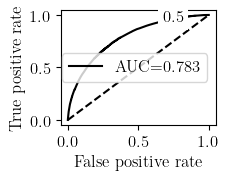

In [22]:
def ROC(y_test, y_proba, p_values, filename):
    print ('ROC()')
    print (filename)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    
    N_median = np.median(y_proba[np.array(y_test)==0])
    P_median = np.median(y_proba[np.array(y_test)==1])
#    print ('N_median, P_median = ', N_median, P_median)

    m = np.quantile(y_proba,0.50)
    p = np.quantile(y_proba,0.25)
    q = np.quantile(y_proba,0.75)
    
    Y = []
    print ('p_values = ', p_values)
    for X in p_values:
        difference_array = np.absolute(thresholds-X)
        index = difference_array.argmin()
        F = fpr[index]
        T = tpr[index]
        Y.append([X,str(round(X,3)),F,T])
    
    auc_value = auc(fpr, tpr)
    auc_value = round(auc_value,3)
    fig = plt.figure(figsize=(2.0,1.5)) # Create matplotlib figure
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, color='black', label='AUC={:.3f}'.format(auc_value))
    
    for y in Y:
#        plt.plot([y[2]], [y[3]], marker="o", markersize=20, markeredgecolor="white", markerfacecolor="white")
#        plt.annotate(
#            y[1], # this is the text
#            (y[2], y[3]), # these are the coordinates to position the label
#            ha='center' # horizontal alignment can be left, right or center
#        )
        plt.text(
            y[2], y[3], # these are the coordinates to position the label
            y[1], # this is the text
            backgroundcolor='white', # horizontal alignment can be left, right or center
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.3')
        )
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
#    plt.title('ROC with AUC {:.3f}'.format(auc_value))
    plt.legend(loc='best')
    plt.savefig('./Images/' + filename + '_ROC.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + filename + '_ROC.pgf', bbox_inches="tight", pad_inches=0.05)
    plt.show()
    plt.close()
    print ()
    return 0

def Test_ROC():
    y_test = [0,0,0,0,0,1]*10000
#    y_proba = [abs(0.45 - y)+round(0.45*random.random(),2) for y in y_test]
    y_proba = [abs(0.45 - y)+round(0.45*random.normalvariate(mu=0.2, sigma=0.2),3) for y in y_test]
#    random.normalvariate(mu=0.0, sigma=1.0)
    y_test = np.array(y_test)
    y_proba = np.array(y_proba)
    print (y_test)
    print (y_proba)
    ROC(y_test, y_proba, [0.5], "tmp")
    
Test_ROC()



In [23]:
def Analyze_Prediction(y_test, y_proba, filename, title):
    print ('Analyze_Prediction()')
    print (filename)
    
    Value_Counts_y_proba(y_proba, filename)
    
#    print (y_test)
#    print (y_proba)
#    return 0
#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    print ('print (len(A), len(C), len(D), len(C) + len(D))')
#    print (len(A), len(C), len(D), len(C) + len(D))

    N = len(C)
    P = len(D)
    
    ##### 10 bins
    n = 10
    bins= [x/n for x in range (-1, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=True)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=True)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    Analyze = pd.DataFrame()
    Analyze['Neg'] = G
    Analyze['Pos'] = H
    Analyze['p'] = bins[1:]
#    Analyze['Neg/Pos'] = Analyze['Neg']/Analyze['Pos']
    Analyze['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] = Analyze['Pos']/(Analyze['Pos'] + Analyze['Neg'])
    Analyze['TN'] = Analyze['Neg'].cumsum()
    Analyze['FP'] = N - Analyze['TN']
    Analyze['FN'] = Analyze['Pos'].cumsum()
    Analyze['TP'] = P - Analyze['FN']
#    Analyze['FP/TP'] = Analyze['FP']/Analyze['TP']
#    Analyze['FP+TP'] = Analyze['FP'] + Analyze['TP']
    Analyze['Prec'] = Analyze['TP']/(Analyze['FP'] + Analyze['TP'])
    Analyze['Rec'] =  Analyze['TP']/(Analyze['FN'] + Analyze['TP'])
    Analyze['$\\frac{\\text{FP}}{\\text{P}}$'] =  Analyze['FP']/(Analyze['FN'] + Analyze['TP'])
    
    Analyze['Neg']=Analyze['Neg'].apply('{:,}'.format)
    Analyze['Pos']=Analyze['Pos'].apply('{:,}'.format)
    Analyze['TN']=Analyze['TN'].apply('{:,}'.format)
    Analyze['FP']=Analyze['FP'].apply('{:,}'.format)
    Analyze['FN']=Analyze['FN'].apply('{:,}'.format)
    Analyze['TP']=Analyze['TP'].apply('{:,}'.format)
#    Analyze['FP+TP']=Analyze['FP+TP'].apply('{:,}'.format)
    
#    Analyze['Neg/Pos']=Analyze['Neg/Pos'].apply('{:.2f}'.format)
    Analyze['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$']=Analyze['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'].apply('{:.2f}'.format)
#    Analyze['FP/TP']=Analyze['FP/TP'].apply('{:.2f}'.format)
    Analyze['Prec']=Analyze['Prec'].apply('{:.2f}'.format)
    Analyze['Rec']=Analyze['Rec'].apply('{:.2f}'.format)
    Analyze['$\\frac{\\text{FP}}{\\text{P}}$']=Analyze['$\\frac{\\text{FP}}{\\text{P}}$'].apply('{:.2f}'.format)
        
#    Analyze.index.name = 'p'
    Analyze.set_index('p', inplace=True)
#    print ('./Analyze_Proba/' + filename + '_10.tex')
#    print (len(y_proba))
#    display(Analyze)
    Analyze.to_csv('./Analyze_Proba/' + filename + '_10.csv', index=True)
    Analyze.to_latex(
        './Analyze_Proba/' + filename + '_10.tex', 
        index=True, 
        float_format="{:.2f}".format, 
        column_format='rrrcrrrrrrrrrrr',
        escape=False
    )



    ##### 20 bins
    n = 20
    bins= [x/n for x in range (-1, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=True)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=True)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    Analyze = pd.DataFrame()
    Analyze['Neg'] = G
    Analyze['Pos'] = H
    Analyze['p'] = bins[1:]
#    Analyze['Neg/Pos'] = Analyze['Neg']/Analyze['Pos']
    Analyze['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] = Analyze['Pos']/(Analyze['Pos'] + Analyze['Neg'])
    Analyze['TN'] = Analyze['Neg'].cumsum()
    Analyze['FP'] = N - Analyze['TN']
    Analyze['FN'] = Analyze['Pos'].cumsum()
    Analyze['TP'] = P - Analyze['FN']
#    Analyze['FP/TP'] = Analyze['FP']/Analyze['TP']
#    Analyze['FP+TP'] = Analyze['FP'] + Analyze['TP']
    Analyze['Prec'] = Analyze['TP']/(Analyze['FP'] + Analyze['TP'])
    Analyze['Rec'] =  Analyze['TP']/(Analyze['FN'] + Analyze['TP'])
    Analyze['$\\frac{\\text{FP}}{\\text{P}}$'] =  Analyze['FP']/(Analyze['FN'] + Analyze['TP'])
    
    Analyze['Neg']=Analyze['Neg'].apply('{:,}'.format)
    Analyze['Pos']=Analyze['Pos'].apply('{:,}'.format)
    Analyze['TN']=Analyze['TN'].apply('{:,}'.format)
    Analyze['FP']=Analyze['FP'].apply('{:,}'.format)
    Analyze['FN']=Analyze['FN'].apply('{:,}'.format)
    Analyze['TP']=Analyze['TP'].apply('{:,}'.format)
#    Analyze['FP+TP']=Analyze['FP+TP'].apply('{:,}'.format)
    
#    Analyze['Neg/Pos']=Analyze['Neg/Pos'].apply('{:.2f}'.format)
    Analyze['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$']=Analyze['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'].apply('{:.2f}'.format)
#    Analyze['FP/TP']=Analyze['FP/TP'].apply('{:.2f}'.format)
    Analyze['Prec']=Analyze['Prec'].apply('{:.2f}'.format)
    Analyze['Rec']=Analyze['Rec'].apply('{:.2f}'.format)
    Analyze['$\\frac{\\text{FP}}{\\text{P}}$']=Analyze['$\\frac{\\text{FP}}{\\text{P}}$'].apply('{:.2f}'.format)
        
#    Analyze.index.name = 'p'
    Analyze.set_index('p', inplace=True)
#    print ('./Analyze_Proba/' + filename + '_10.tex')
#    print (len(y_proba))
#    display(Analyze)
    Analyze.to_csv('./Analyze_Proba/' + filename + '_20.csv', index=True)
    Analyze.to_latex(
        './Analyze_Proba/' + filename + '_20.tex', 
        index=True, 
        float_format="{:.2f}".format, 
        column_format='rrrcrrrrrrrrrrr',
        escape=False
    )




    ##### 100 bins
    n = 100
    bins= [x/n for x in range (-1, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=True)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=True)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    Analyze = pd.DataFrame()
    Analyze['Neg'] = G
    Analyze['Pos'] = H
    Analyze['p'] = bins[1:]
#    Analyze['Neg/Pos'] = Analyze['Neg']/Analyze['Pos']
    Analyze['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] = Analyze['Pos']/(Analyze['Pos'] + Analyze['Neg'])
    Analyze['TN'] = Analyze['Neg'].cumsum()
    Analyze['FP'] = N - Analyze['TN']
    Analyze['FN'] = Analyze['Pos'].cumsum()
    Analyze['TP'] = P - Analyze['FN']
#    Analyze['FP/TP'] = Analyze['FP']/Analyze['TP']
#    Analyze['FP+TP'] = Analyze['FP'] + Analyze['TP']
    Analyze['Prec'] = Analyze['TP']/(Analyze['FP'] + Analyze['TP'])
    Analyze['Rec'] =  Analyze['TP']/(Analyze['FN'] + Analyze['TP'])
    Analyze['$\\frac{\\text{FP}}{\\text{P}}$'] =  Analyze['FP']/(Analyze['FN'] + Analyze['TP'])
    
    A = Analyze.copy(deep=True)
    
    Analyze['Neg']=Analyze['Neg'].apply('{:,}'.format)
    Analyze['Pos']=Analyze['Pos'].apply('{:,}'.format)
    Analyze['TN']=Analyze['TN'].apply('{:,}'.format)
    Analyze['FP']=Analyze['FP'].apply('{:,}'.format)
    Analyze['FN']=Analyze['FN'].apply('{:,}'.format)
    Analyze['TP']=Analyze['TP'].apply('{:,}'.format)
#    Analyze['FP+TP']=Analyze['FP+TP'].apply('{:,}'.format)
    
#    Analyze['Neg/Pos']=Analyze['Neg/Pos'].apply('{:.2f}'.format)
    Analyze['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$']=Analyze['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'].apply('{:.2f}'.format)
#    Analyze['FP/TP']=Analyze['FP/TP'].apply('{:.2f}'.format)
    Analyze['Prec']=Analyze['Prec'].apply('{:.2f}'.format)
    Analyze['Rec']=Analyze['Rec'].apply('{:.2f}'.format)
    Analyze['$\\frac{\\text{FP}}{\\text{P}}$']=Analyze['$\\frac{\\text{FP}}{\\text{P}}$'].apply('{:.2f}'.format)
        
#    Analyze.index.name = 'p'
    Analyze.set_index('p', inplace=True)
#    print ('./Analyze_Proba/' + filename + '_10.tex')
#    print (len(y_proba))
#    display(Analyze)
    Analyze.to_csv('./Analyze_Proba/' + filename + '_100.csv', index=True)
    Analyze.to_latex(
        './Analyze_Proba/' + filename + '_100.tex', 
        index=True, 
        float_format="{:.2f}".format, 
        column_format='rrrcrrrrrrrrrrr',
        escape=False
    )



In [24]:
def Value_Counts_y_proba(y_proba, filename):
#    print ()
    print ('Value_Counts_y_proba')
#    print (type(y_proba))
    Y_proba = pd.Series(y_proba)
    A = Y_proba.value_counts().reset_index(drop=True)
    n = len(y_proba)
    nA = len(A)
#    display(Y_proba)
#    display(A)
    B = A.cumsum()
#    display(B)
#    print (B[10])
#    print ()
    cutoff_95 = B.sub(0.95*n).abs().idxmin() + 1
    cutoff_90 = B.sub(0.90*n).abs().idxmin() + 1
    cutoff_80 = B.sub(0.80*n).abs().idxmin() + 1
    print (n, nA)
    print (cutoff_95)
#    print ()

    n100 = min(100, len(B)-1)
    n200 = min(200, len(B)-1)
#    print ('n200 = ', n200)
    f = open('./Analyze_Proba/Value_Counts_y_proba.csv', 'a')
    f.write('%s,%d,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f\n' % (
        filename, n, nA, nA/n, 
        cutoff_95, cutoff_95/n,
        cutoff_90, cutoff_90/n,
        cutoff_80, cutoff_80/n,
        B[10], B[10]/n,
        B[20], B[20]/n,
        B[n100], B[n100]/n,
        B[n200], B[n200]/n,
    ))
    f.close()
    
    H = Y_proba.value_counts().head(100)
    Filename = './Analyze_Proba/' + filename + '_Value_Counts.csv'
    H.to_csv(Filename)
    
    
    print ('Finished')
    return 0
    
def Create_Files_for_Value_Counts_y_proba():
    f = open('./Analyze_Proba/Value_Counts_y_proba.csv', 'w')
    f.write("Filename,n,nUnique,nUnique/n,95%,95%/n,90%,90%/n,80%,80%/n,B[10],B[10]/n,B[20],B[20]/n,B[100],B[100]/n,B[200],B[200]/n,\n")
    f.close()
    
#Create_Files_for_Value_Counts_y_proba()

def Create_Files_for_Lengths_of_fpr_tpr():
    f = open('./Analyze_Proba/Lengths_of_fpr_tpr.csv', 'w')
    f.write("Filename,len(y_proba),nUnique(y_proba),len(fpr),nUnique(fpr),len(tpr),nUnique(tpr),len(fpr tpr),nUnique(fpr tpr)\n")
    f.close()
    
    
    
def Test_Value_Counts_y_proba():
    A = [5]*50 + [6]*20 + [i for i in range (10,40)]*2 + [i for i in range (100,400)]
    Value_Counts_y_proba(A, 'Test')

Test_Value_Counts_y_proba()

    


Value_Counts_y_proba
430 332
310
Finished


## Build Idealized Results Plots
- The Plot_Prediciton and ROC_Curves functions take two lists (or np arrays) and a filename for saving the plots:
    - ROC(y_test, y_proba, filename):
    - Plot_Prediction(y_test, y_proba, filename):
    - y_test is the {0,1} binary and 
    - y_proba is the (0,1) continuous
- The Evaluate_Model(y_test, y_proba, y_pred, filename) takes three lists (or np arrays)
    - y_test is the {0,1} binary ground truth,
    - y_proba is the (0,1) continuous prediction, and
    - y_pred is the discrete {0,1} binary version of y_proba
- We want a 

Idealized_Results()
min(a) =  0.014771681133732149
Move_Threshold()
<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.ndarray'>
85000 15000


,0,1,2,3,4,5,6
0,t,TN,FP,FN,TP,TPR,FPR
1,0.0,0,85000,0,15000,1.0,1.0
2,0.1,2495,82505,113,14887,0.992467,0.970647
3,0.2,16258,68742,355,14645,0.976333,0.808729
4,0.3,36383,48617,803,14197,0.946467,0.571965
5,0.4,54769,30231,1679,13321,0.888067,0.355659
6,0.5,67906,17094,3196,11804,0.786933,0.201106
7,0.6,75913,9087,5454,9546,0.6364,0.106906
8,0.7,81110,3890,8677,6323,0.421533,0.045765
9,0.8,83486,1514,12237,2763,0.1842,0.017812



Ideal
Plot_Prediction()
Ideal
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


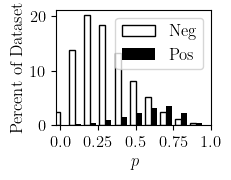


Plot_Prediction()
Ideal
./Images/Ideal_Pred_Wide.png


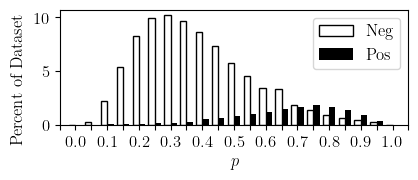


Plot_Prediction()
Ideal_0_0
len(C), len(D), len(TN), len(FP), len(FN), len(TP)
85000 15000 0 85000 0 15000

len(TP_vc) =  21


/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  TN = C[A['HOSPITAL'] < threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  FP = C[A['HOSPITAL'] >= threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  FN = D[A['HOSPITAL'] < threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  TP = D[A['HOSPITAL'] >= threshold]


../../Dissertation_03_26_24/Figures/Ideal_0_0_Pred_Wide_Threshold.pgf


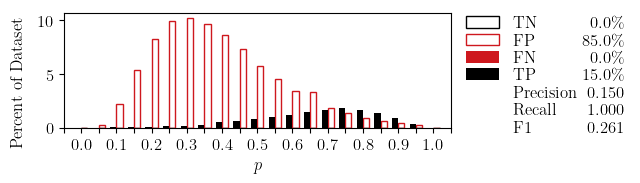


Plot_Prediction()
Ideal_0_5
len(C), len(D), len(TN), len(FP), len(FN), len(TP)
85000 15000 67906 17094 3196 11804

len(TP_vc) =  21


/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  TN = C[A['HOSPITAL'] < threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  FP = C[A['HOSPITAL'] >= threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  FN = D[A['HOSPITAL'] < threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  TP = D[A['HOSPITAL'] >= threshold]


../../Dissertation_03_26_24/Figures/Ideal_0_5_Pred_Wide_Threshold.pgf


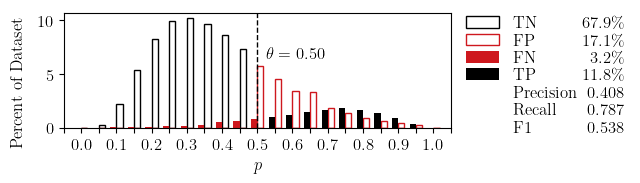


Plot_Prediction()
Ideal_0_6
len(C), len(D), len(TN), len(FP), len(FN), len(TP)
85000 15000 75913 9087 5454 9546

len(TP_vc) =  21


/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  TN = C[A['HOSPITAL'] < threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  FP = C[A['HOSPITAL'] >= threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  FN = D[A['HOSPITAL'] < threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  TP = D[A['HOSPITAL'] >= threshold]


../../Dissertation_03_26_24/Figures/Ideal_0_6_Pred_Wide_Threshold.pgf


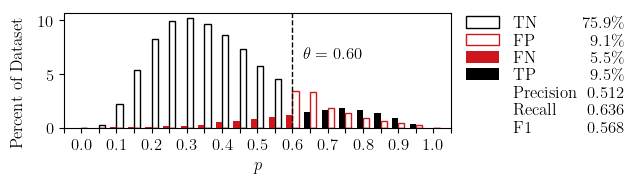


Plot_Prediction()
Ideal_0_7
len(C), len(D), len(TN), len(FP), len(FN), len(TP)
85000 15000 81110 3890 8677 6323

len(TP_vc) =  21


/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  TN = C[A['HOSPITAL'] < threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  FP = C[A['HOSPITAL'] >= threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  FN = D[A['HOSPITAL'] < threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  TP = D[A['HOSPITAL'] >= threshold]


../../Dissertation_03_26_24/Figures/Ideal_0_7_Pred_Wide_Threshold.pgf


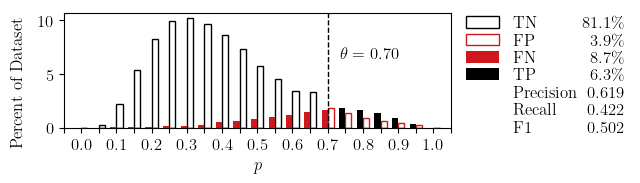


Plot_Prediction()
Ideal_0_8
len(C), len(D), len(TN), len(FP), len(FN), len(TP)
85000 15000 83486 1514 12237 2763

len(TP_vc) =  21
../../Dissertation_03_26_24/Figures/Ideal_0_8_Pred_Wide_Threshold.pgf


/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  TN = C[A['HOSPITAL'] < threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  FP = C[A['HOSPITAL'] >= threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  FN = D[A['HOSPITAL'] < threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  TP = D[A['HOSPITAL'] >= threshold]


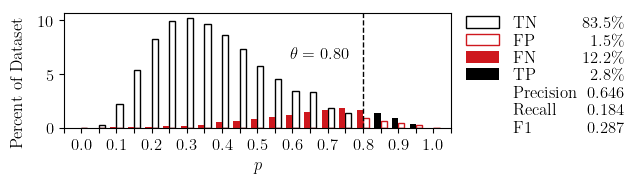


Plot_Prediction()
Ideal_0_9
len(C), len(D), len(TN), len(FP), len(FN), len(TP)
85000 15000 84667 333 14545 455

len(TP_vc) =  21
../../Dissertation_03_26_24/Figures/Ideal_0_9_Pred_Wide_Threshold.pgf


/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  TN = C[A['HOSPITAL'] < threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  FP = C[A['HOSPITAL'] >= threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  FN = D[A['HOSPITAL'] < threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  TP = D[A['HOSPITAL'] >= threshold]


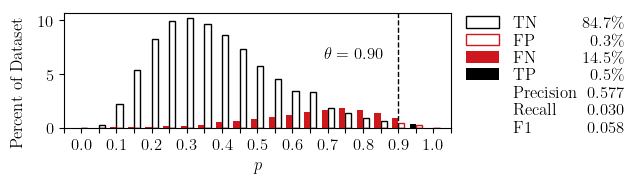


Plot_Prediction()
Ideal_0_55
len(C), len(D), len(TN), len(FP), len(FN), len(TP)
85000 15000 72464 12536 4238 10762

len(TP_vc) =  21


/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  TN = C[A['HOSPITAL'] < threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  FP = C[A['HOSPITAL'] >= threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  FN = D[A['HOSPITAL'] < threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  TP = D[A['HOSPITAL'] >= threshold]


../../Dissertation_03_26_24/Figures/Ideal_0_55_Pred_Wide_Threshold.pgf


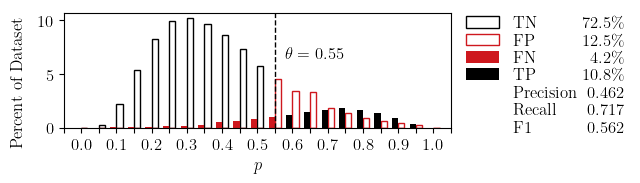


Plot_Prediction()
Ideal_0_65
len(C), len(D), len(TN), len(FP), len(FN), len(TP)
85000 15000 79235 5765 6950 8050

len(TP_vc) =  21
../../Dissertation_03_26_24/Figures/Ideal_0_65_Pred_Wide_Threshold.pgf


/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  TN = C[A['HOSPITAL'] < threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  FP = C[A['HOSPITAL'] >= threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  FN = D[A['HOSPITAL'] < threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  TP = D[A['HOSPITAL'] >= threshold]


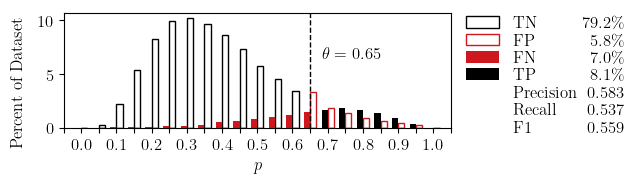


Plot_Prediction()
Ideal_0_75
len(C), len(D), len(TN), len(FP), len(FN), len(TP)
85000 15000 82515 2485 10535 4465

len(TP_vc) =  21
../../Dissertation_03_26_24/Figures/Ideal_0_75_Pred_Wide_Threshold.pgf


/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  TN = C[A['HOSPITAL'] < threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  FP = C[A['HOSPITAL'] >= threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  FN = D[A['HOSPITAL'] < threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  TP = D[A['HOSPITAL'] >= threshold]


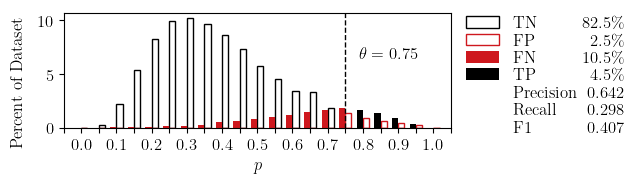


Plot_Prediction()
Ideal_0_85
len(C), len(D), len(TN), len(FP), len(FN), len(TP)
85000 15000 84187 813 13614 1386

len(TP_vc) =  21
../../Dissertation_03_26_24/Figures/Ideal_0_85_Pred_Wide_Threshold.pgf


/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  TN = C[A['HOSPITAL'] < threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  FP = C[A['HOSPITAL'] >= threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  FN = D[A['HOSPITAL'] < threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  TP = D[A['HOSPITAL'] >= threshold]


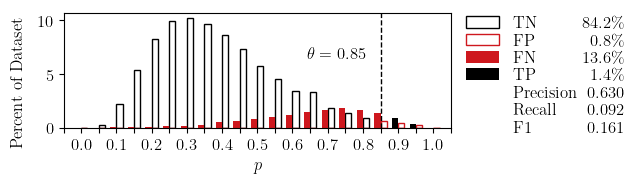


Plot_Prediction()
Ideal_0_95
len(C), len(D), len(TN), len(FP), len(FN), len(TP)
85000 15000 85000 0 14952 48

len(TP_vc) =  21


/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  TN = C[A['HOSPITAL'] < threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  FP = C[A['HOSPITAL'] >= threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  FN = D[A['HOSPITAL'] < threshold]
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/3048836870.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  TP = D[A['HOSPITAL'] >= threshold]


../../Dissertation_03_26_24/Figures/Ideal_0_95_Pred_Wide_Threshold.pgf


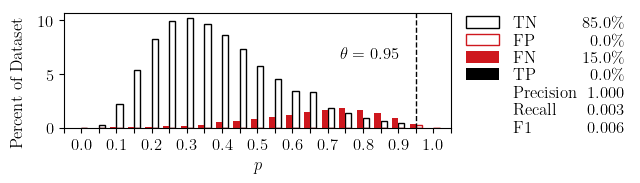


Plot_Prediction_Zoom_Wide_Right() for  Ideal


/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/2681567574.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  B = B[A['HOSPITAL'] < right]


ROC()
Ideal
p_values =  []


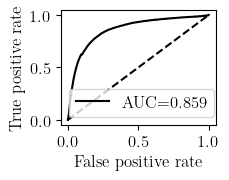


Evaluate_Model()
np.unique(y_proba) =  [0.00059518 0.00114011 0.00158985 ... 0.98283528 0.98455671 0.98776071]
np.unique(y_pred) =  [0 1]
[[67906 17094]
 [ 3196 11804]]

[[0.67906 0.17094]
 [0.03196 0.11804]]

0.408 & Precision \cr 
0.787 & Recall \cr 
0.538 & F1 \cr 
Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000356 0.000005   ... 0.88283528 0.88455671 0.88776071]
np.unique(y_pred) =  [0 1]
[[75913  9087]
 [ 5454  9546]]

[[0.75913 0.09087]
 [0.05454 0.09546]]

0.512 & Precision \cr 
0.636 & Recall \cr 
0.568 & F1 \cr 
Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000165 0.00000725 ... 0.78283528 0.78455671 0.78776071]
np.unique(y_pred) =  [0 1]
[[81110  3890]
 [ 8677  6323]]

[[0.8111  0.0389 ]
 [0.08677 0.06323]]

0.619 & Precision \cr 
0.422 & Recall \cr 
0.502 & F1 \cr 
Evaluate_Model()
np.unique(y_proba) =  [0.         0.00001293 0.00001481 ... 0.68283528 0.68455671 0.68776071]
np.unique(y_pred) =  [0 1]
[[83486  1514]
 [12237  2763]]

[[0.83486 0.01514]
 [0

/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/2659243470.py:69: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  Analyze.to_latex(
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/2659243470.py:126: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  Analyze.to_latex(
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/2659243470.py:186: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementati

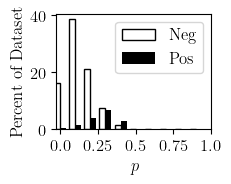


ROC()
Ideal_Left
p_values =  []


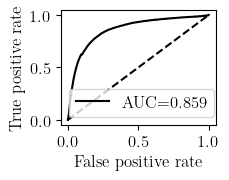


Evaluate_Model()
np.unique(y_proba) =  [0.00029759 0.00057006 0.00079492 ... 0.49141764 0.49227836 0.49388036]
np.unique(y_pred) =  [0]
[[85000     0]
 [15000     0]]

[[0.85 0.  ]
 [0.15 0.  ]]

0.000 & Precision \cr 
0.000 & Recall \cr 
0.000 & F1 \cr 
Analyze_Prediction()
Ideal_Left
Value_Counts_y_proba
100000 99194
94194
Finished

Ideal_Left_Shifted
Shift_y_proba()

N_median = 0.165, P_median = 0.333, center = 0.249
N_median = 0.416, P_median = 0.584, center = 0.500

Plot_Prediction()
Ideal_Left_Shifted
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/2888639073.py:24: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(FP+TP)
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/2659243470.py:69: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  Analyze.to_latex(
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_23272/2659243470.py:126: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  Analyze.to_latex(
/var/folders/c3/

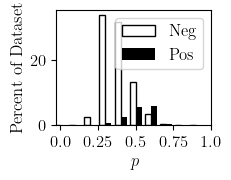


ROC()
Ideal_Left_Shifted
p_values =  []


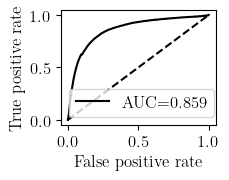


Evaluate_Model()
np.unique(y_proba) =  [0.2509631  0.25123557 0.25146043 ... 0.74208315 0.74294387 0.74454587]
np.unique(y_pred) =  [0 1]
[[67757 17243]
 [ 3173 11827]]

[[0.67757 0.17243]
 [0.03173 0.11827]]

0.407 & Precision \cr 
0.788 & Recall \cr 
0.537 & F1 \cr 

Ideal_Left_Linear_Transform
Linear_Transform_y_proba()

a = 0.311, b = 0.691

Plot_Prediction()
Ideal_Left_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


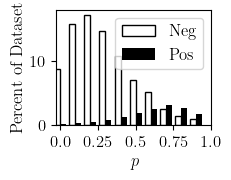


ROC()
Ideal_Left_Linear_Transform
p_values =  []


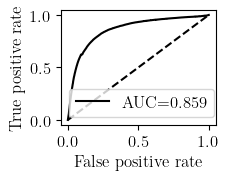


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000921 0.00005233 ... 0.9997513  0.99990086 1.        ]
np.unique(y_pred) =  [0 1]
[[67908 17092]
 [ 3197 11803]]

[[0.67908 0.17092]
 [0.03197 0.11803]]

0.408 & Precision \cr 
0.787 & Recall \cr 
0.538 & F1 \cr 

Ideal_Right
Plot_Prediction()
Ideal_Right
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


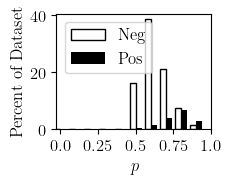


ROC()
Ideal_Right
p_values =  []


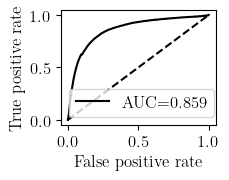


Evaluate_Model()
np.unique(y_proba) =  [0.50029759 0.50057006 0.50079492 ... 0.99141764 0.99227836 0.99388036]
np.unique(y_pred) =  [1]
[[    0 85000]
 [    0 15000]]

[[0.   0.85]
 [0.   0.15]]

0.150 & Precision \cr 
1.000 & Recall \cr 
0.261 & F1 \cr 

Ideal_Right_Shifted
Shift_y_proba()

N_median = 0.665, P_median = 0.833, center = 0.749
N_median = 0.416, P_median = 0.584, center = 0.500

Plot_Prediction()
Ideal_Right_Shifted
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


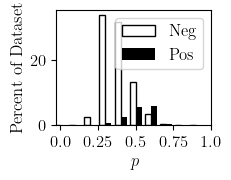


ROC()
Ideal_Right_Shifted
p_values =  []


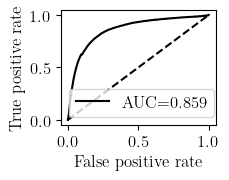


Evaluate_Model()
np.unique(y_proba) =  [0.2509631  0.25123557 0.25146043 ... 0.74208315 0.74294387 0.74454587]
np.unique(y_pred) =  [0 1]
[[67757 17243]
 [ 3173 11827]]

[[0.67757 0.17243]
 [0.03173 0.11827]]

0.407 & Precision \cr 
0.788 & Recall \cr 
0.537 & F1 \cr 

Ideal_Right_Linear_Transform
Linear_Transform_y_proba()

a = 0.311, b = 0.691

Plot_Prediction()
Ideal_Right_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


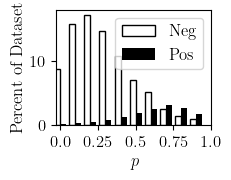


ROC()
Ideal_Right_Linear_Transform
p_values =  []


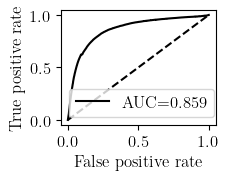


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000921 0.00005233 ... 0.9997513  0.99990086 1.        ]
np.unique(y_pred) =  [0 1]
[[67908 17092]
 [ 3197 11803]]

[[0.67908 0.17092]
 [0.03197 0.11803]]

0.408 & Precision \cr 
0.787 & Recall \cr 
0.538 & F1 \cr 

Ideal_Tight
Plot_Prediction()
Ideal_Tight
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


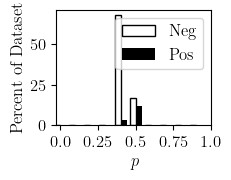


ROC()
Ideal_Tight
p_values =  [0.3309237132058226, 0.5, 0.6664142444754466]


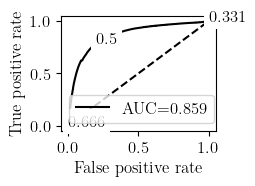


Evaluate_Model()
np.unique(y_proba) =  [0.40011904 0.40022802 0.40031797 ... 0.59656706 0.59691134 0.59755214]
np.unique(y_pred) =  [0 1]
[[67906 17094]
 [ 3196 11804]]

[[0.67906 0.17094]
 [0.03196 0.11804]]

0.408 & Precision \cr 
0.787 & Recall \cr 
0.538 & F1 \cr 



In [25]:
def Move_Threshold(y_proba, y_test):
    print ('Move_Threshold()')
    n = 10
    T = [x/n for x in range (n+1)]
    
    print (type(y_proba))
    print (type(y_test))
    y_test = np.array(y_test)
    print (type(y_test))
    N = y_proba[y_test==0]
    P = y_proba[y_test==1]
    print (len(N), len(P))

    A = [['t', 'TN', 'FP', 'FN', 'TP', 'TPR', 'FPR']]
    for t in T:
        TN = len(N[N<t])
        FP = len(N[N>t])
        FN = len(P[P<t])
        TP = len(P[P>t])
        TPR = TP/len(P)
        FPR = FP/len(N)
        A.append([t, TN, FP, FN, TP, TPR, FPR])
    display(pd.DataFrame(A))
    
    print ()


def Idealized_Results():
    print ('Idealized_Results()')
    # Set randomness
    np.random.seed(42) # NumPy
    random.seed(42) # Python
    tf.random.set_seed(42) # Tensorflow    

    shape, scale = 3.8, 0.1 # mean=4, std=2*sqrt(2)
#    a = np.random.gamma(shape, scale, 605610)
    a = np.random.gamma(shape, scale, 85000)
    a = np.where(a>1.0, random.random(), a)
    a = np.where(a<0.0, random.random(), a)
    a = a*0.95
    print ('min(a) = ', min(a))
    
    shape, scale = 3.7, 0.1 # mean=4, std=2*sqrt(2)
#    b = np.random.gamma(shape, scale, 107956)    
    b = np.random.gamma(shape, scale, 15000)
#    b = b*0.95
    b = np.where(b>1.0, random.random(), b)
    b = 1-b
    
    y_proba = np.concatenate((a,b),axis=0)
    Y_PROBA = np.concatenate((a,b),axis=0)
    y_pred = K.round(y_proba)
    y_test = [0]*len(a) + [1]*len(b)
    N_median = np.median(a)
    P_median = np.median(b)
    
    Move_Threshold(y_proba, y_test)
    
    filename = 'Ideal'
    print (filename)
    title = 'Original Example'
    Plot_Prediction(y_test, y_proba, filename, title)
    Plot_Prediction_Wide(y_test, y_proba, filename, title)
    Plot_Prediction_Wide_Threshold_Dissertation(y_test, y_proba, 0.0, filename + '_0_0', title)
    Plot_Prediction_Wide_Threshold_Dissertation(y_test, y_proba, 0.5, filename + '_0_5', title)
    Plot_Prediction_Wide_Threshold_Dissertation(y_test, y_proba, 0.6, filename + '_0_6', title)
    Plot_Prediction_Wide_Threshold_Dissertation(y_test, y_proba, 0.7, filename + '_0_7', title)
    Plot_Prediction_Wide_Threshold_Dissertation(y_test, y_proba, 0.8, filename + '_0_8', title)
    Plot_Prediction_Wide_Threshold_Dissertation(y_test, y_proba, 0.9, filename + '_0_9', title)
    Plot_Prediction_Wide_Threshold_Dissertation(y_test, y_proba, 0.55, filename + '_0_55', title)
    Plot_Prediction_Wide_Threshold_Dissertation(y_test, y_proba, 0.65, filename + '_0_65', title)
    Plot_Prediction_Wide_Threshold_Dissertation(y_test, y_proba, 0.75, filename + '_0_75', title)
    Plot_Prediction_Wide_Threshold_Dissertation(y_test, y_proba, 0.85, filename + '_0_85', title)
    Plot_Prediction_Wide_Threshold_Dissertation(y_test, y_proba, 0.95, filename + '_0_95', title)
    Plot_Prediction_Zoom_Wide_Right(y_test, y_proba, filename, title)
    ROC(y_test, y_proba, [], filename)    
#    ROC(y_test, y_proba, [N_median, 0.5, P_median], filename)    
    Evaluate_Model(y_test, y_proba, y_pred, 0.5, filename + '_0_5')    
    Evaluate_Model(y_test, y_proba, y_pred, 0.6, filename + '_0_6')    
    Evaluate_Model(y_test, y_proba, y_pred, 0.7, filename + '_0_7')    
    Evaluate_Model(y_test, y_proba, y_pred, 0.8, filename + '_0_8')    
    Evaluate_Model(y_test, y_proba, y_pred, 0.9, filename + '_0_9')    
    Analyze_Prediction(y_test, y_proba, filename, title)
    print ()
    
    filename = 'Ideal_Left'
    title = 'Never Ambulance'
    print (filename)
    y_proba = 0.5 * y_proba
    y_pred = K.round(y_proba)
    Plot_Prediction(y_test, y_proba, filename, title)
    ROC(y_test, y_proba, [], filename)    
#    ROC(y_test, y_proba, [N_median, 0.5, P_median], filename)    
    Evaluate_Model(y_test, y_proba, y_pred, 0.5, filename)    
    Analyze_Prediction(y_test, y_proba, filename, title)
    print ()

    filename = 'Ideal_Left_Shifted'
    title = ''
    print (filename)
    y_test, y_proba, y_pred, filename = Shift_y_proba(y_test, y_proba, y_pred, filename)
    Plot_Prediction(y_test, y_proba, filename, title)
    ROC(y_test, y_proba, [], filename)    
    Evaluate_Model(y_test, y_proba, y_pred, 0.5, filename)    
    print ()
    
    filename = 'Ideal_Left_Linear_Transform'
    title = ''
    print (filename)
    y_test, y_proba, y_pred, filename = Linear_Transform_y_proba(y_test, y_proba, y_pred, filename)
    Plot_Prediction(y_test, y_proba, filename, title)
    ROC(y_test, y_proba, [], filename)    
    Evaluate_Model(y_test, y_proba, y_pred, 0.5, filename)    
    print ()
    
    filename = 'Ideal_Right'
    title = 'Always Ambulance'
    print (filename)
    y_proba = 0.5 * Y_PROBA + 0.5
    y_pred = K.round(y_proba)
    Plot_Prediction(y_test, y_proba, filename, title)
    ROC(y_test, y_proba, [], filename)    
#    ROC(y_test, y_proba, [N_median, 0.5, P_median], filename)    
    Evaluate_Model(y_test, y_proba, y_pred, 0.5, filename)    
    print ()

    filename = 'Ideal_Right_Shifted'
    title = ''
    print (filename)
    y_test, y_proba, y_pred, filename = Shift_y_proba(y_test, y_proba, y_pred, filename)
    Plot_Prediction(y_test, y_proba, filename, title)
    ROC(y_test, y_proba, [], filename)    
    Evaluate_Model(y_test, y_proba, y_pred, 0.5, filename)    
    print ()
    
    filename = 'Ideal_Right_Linear_Transform'
    title = ''
    print (filename)
    y_test, y_proba, y_pred, filename = Linear_Transform_y_proba(y_test, y_proba, y_pred, filename)
    Plot_Prediction(y_test, y_proba, filename, title)
    ROC(y_test, y_proba, [], filename)    
    Evaluate_Model(y_test, y_proba, y_pred, 0.5, filename)    
    print ()
    
    y_proba = Y_PROBA
    y_pred = K.round(y_proba)
    y_test = [0]*len(a) + [1]*len(b)
    
    filename = 'Ideal_Tight'
    title = 'Tight'
    print (filename)
    y_proba = 0.2 * Y_PROBA + 0.4
    y_pred = K.round(y_proba)
    Plot_Prediction(y_test, y_proba, filename, title)
    ROC(y_test, y_proba, [N_median, 0.5, P_median], filename)    
    Evaluate_Model(y_test, y_proba, y_pred, 0.5, filename)    
    print ()
    
"""
   
    y_proba = Y_PROBA
    y_pred = K.round(y_proba)
    y_test = [0]*len(a) + [1]*len(b)
    
    filename = 'Ideal_Shift_to_FP_equals_r_TP'
    title = 'Transformed'
    print (filename)
    y_test, y_proba, y_pred, p_target, filename_tmp = Shift_y_proba_to_FP_equals_r_TP(y_test, y_proba, 2.0, filename)
    print ('type(y_test) = ', type(y_test))
    N = y_proba[np.array(y_test)==0]
    P = y_proba[np.array(y_test)==1]
    display(N)
    N_median = np.median(N)
    P_median = np.median(P)
    Plot_Prediction(y_test, y_proba, filename, title)
    ROC(y_test, y_proba, [N_median, P_median], filename)    
    Evaluate_Model(y_test, y_proba, y_pred, 0.5, filename)    
    print ()
"""    
    

    
Idealized_Results()

Plot_Prediction()
Awful
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


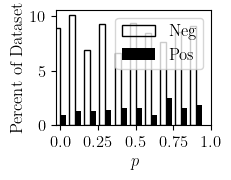


ROC()
Awful
p_values =  []


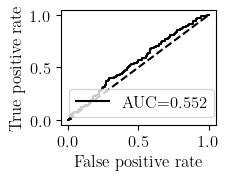


Evaluate_Model()
np.unique(y_proba) =  [0.00463202 0.00506158 0.00552212 0.00695213 0.00919705 0.01083765
 0.01135364 0.01215447 0.01309446 0.01439349 0.01454467 0.01545662
 0.01559782 0.01658783 0.01811018 0.01822183 0.0200712  0.02058449
 0.02327194 0.02431597 0.02535074 0.02541913 0.02636697 0.02651131
 0.02878268 0.03050025 0.03142919 0.03353243 0.03438852 0.03594227
 0.0366832  0.03688695 0.03734819 0.03931214 0.0407288  0.04077514
 0.04086862 0.04315991 0.04521867 0.04522729 0.04530401 0.04544638
 0.04600264 0.04645041 0.04976265 0.05147875 0.05154669 0.05168172
 0.05182354 0.05388454 0.05476164 0.05630328 0.0563755  0.05755876
 0.05808361 0.06107796 0.06317026 0.06337497 0.06355835 0.06505159
 0.06649627 0.0693613  0.07056875 0.07118865 0.07276301 0.07379656
 0.07404465 0.07455064 0.07586333 0.07697991 0.07773464 0.07845638
 0.08023375 0.08134878 0.08175903 0.08268642 0.08350072 0.08410681
 0.08413996 0.08483771 0.08534746 0.08534967 0.08558805 0.08570119
 0.08692029 0.0884925 

In [26]:
def Awful_Results():
    # Set randomness
    np.random.seed(42) # NumPy
    random.seed(42) # Python
    tf.random.set_seed(42) # Tensorflow    
    
    
    shape, scale = 1.0, 0.5 # mean=4, std=2*sqrt(2)
    a = np.random.random(850)   
    
    b = np.random.random(150)    
    b = np.where(b>1.0, random.random(), b)
    b = 1-b
    
    y_proba = np.concatenate((a,b),axis=0)
    y_pred = K.round(y_proba)
    y_test = [0]*len(a) + [1]*len(b)
    
    filename = 'Awful'
    title = 'Awful'
    Plot_Prediction(y_test, y_proba, filename, title)
    ROC(y_test, y_proba, [], filename)    
    Evaluate_Model(y_test, y_proba, y_pred, 0.5, filename)    
    
Awful_Results()